In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score


In [2]:

# 2. Load Datasets
df = pd.read_csv(r"C:\Users\nithi\OneDrive - St. Clair College\322-capstone-project\benefits-and-cost-sharing-puf\cleaned_benefits_data.csv")
group_ref = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\BENEFIT_GROUPED.csv")


C:\Users\nithi\AppData\Local\Temp\ipykernel_3832\960638996.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\nithi\OneDrive - St. Clair College\322-capstone-project\benefits-and-cost-sharing-puf\cleaned_benefits_data.csv")


In [3]:
# 4. Drop Irrelevant Columns
irrelevant_cols = ["BusinessYear", "IssuerId", "StandardComponentId", "PlanId", "SourceName", "ImportDate",'CopayInnText_2', 'MOOP_Rank','Coverage_Rank', 'Cost_Rank', 'BenefitGroupID','LimitQty', 'LimitUnit', 'Explanation',
       'EHBVarReason','QuantLimitOnSvc','CopayInnText']
df.drop(columns=[col for col in irrelevant_cols if col in df.columns], inplace=True, errors='ignore')


In [7]:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import hstack

# Load datasets
df = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\cleaned_benefits_data.csv", low_memory=False)
group_map = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\benefit_supercategories_cleaned.csv", low_memory=False)

# Preprocess BenefitName and merge with group_map
df["BenefitName"] = df["BenefitName"].astype(str).str.strip().str.title()
group_map["BenefitName"] = group_map["BenefitName"].astype(str).str.strip().str.title()
df = pd.merge(df, group_map[["BenefitName", "SuperCategoryID"]], on="BenefitName", how="left")
df = df[df["SuperCategoryID"].notna() & (df["SuperCategoryID"] != -1)]
df["SuperCategoryID"] = df["SuperCategoryID"].astype(int)

# Normalize cost-related fields
cost_cols = [
    "CopayInnAmount", "CopayInnAmount_2", "CopayOutofNet",
    "CoinsInnTier1", "CoinsInnTier2", "CoinsOutofNet", "MOOP"
]
for col in cost_cols:
    df[col] = df[col].astype(str).str.replace("Not Applicable", "0", case=False)
    df[col] = df[col].str.replace(r"[^\d.]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[f"{col}_was_zero"] = (df[col] == 0).astype(int)
    df[col] = np.clip(df[col], 0, df[col].quantile(0.99))
df[cost_cols] = df[cost_cols].fillna(df[cost_cols].median())

# Encode boolean fields
bool_map = {"Yes": 1, "No": 0, "Covered": 1, "Not Covered": 0}
bool_fields = ["IsEHB", "IsCovered", "IsExclFromInnMOOP", "IsExclFromOonMOOP"]
for col in bool_fields:
    df[col] = df[col].map(bool_map).fillna(0).astype(int)

# Prepare numeric features
binary_flags = [f"{col}_was_zero" for col in cost_cols]
numeric_features = cost_cols + binary_flags + bool_fields
X_numeric = df[numeric_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_numeric)
y = df["SuperCategoryID"]

# Vectorizer with stop words removed
vectorizer = TfidfVectorizer(
    max_features=50,
    ngram_range=(1, 2),
    stop_words='english'  # Removes generic, low-meaning words like "or", "for", etc.
)
benefit_vectors = vectorizer.fit_transform(df["BenefitName"])
X_combined = hstack([benefit_vectors, X_scaled])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost model
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Save model and preprocessors
joblib.dump(model, r"C:\Users\nithi\Downloads\ML-model\xgb_benefit_classifier.pkl")
joblib.dump(vectorizer, r"C:\Users\nithi\Downloads\ML-model\benefitname_vectorizer.pkl")
joblib.dump(scaler, r"C:\Users\nithi\Downloads\ML-model\numeric_scaler.pkl")

# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)



print("✅ Final Model Saved")
print("Accuracy:", round(acc * 100, 2), "%")
print("F1 Score (macro):", round(f1, 4))
print("\nClassification Report:\n", report)    



C:\Users\nithi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:43:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final Model Saved
Accuracy: 84.28 %
F1 Score (macro): 0.8415

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.30      0.46     12596
           1       1.00      1.00      1.00     28349
           2       0.90      0.81      0.85      9566
           3       0.89      0.93      0.91     14599
           4       0.86      0.66      0.75     14599
           5       0.96      0.98      0.97     14981
           6       0.61      0.85      0.71     26289
           7       1.00      1.00      1.00     12276
           8       0.82      1.00      0.90     11690
           9       0.73      0.68      0.70     17761
          10       1.00      1.00      1.00     14599
          11       0.68      0.70      0.69     17519
          12       1.00      1.00      1.00      8759

    accuracy                           0.84    203583
   macro avg       0.88      0.84      0.84    203583
weighted avg       0.86      0.84      0.84   

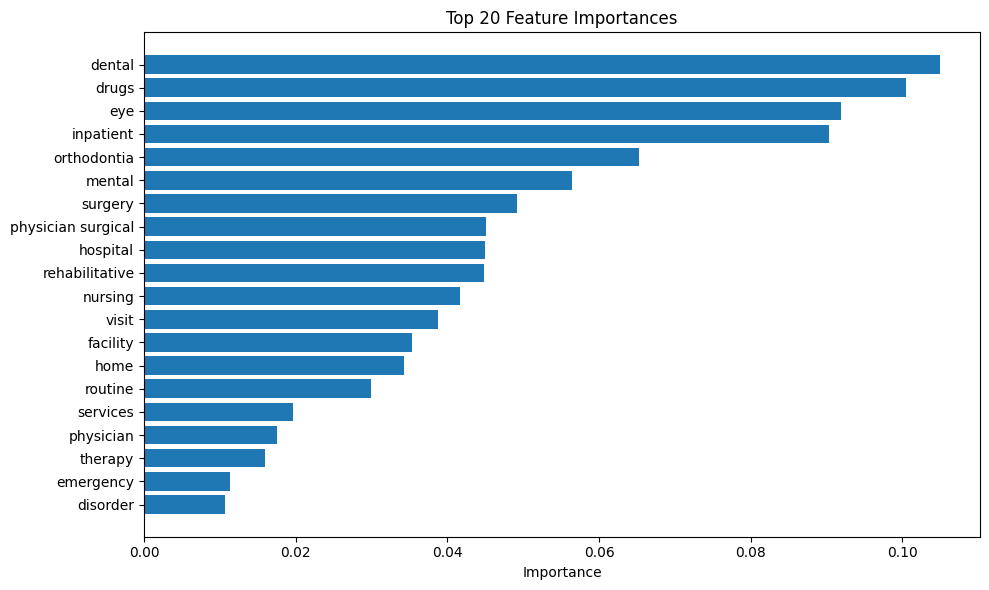

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names from TF-IDF vectorizer
vectorizer_features = vectorizer.get_feature_names_out()

# Combine with numeric feature names
all_feature_names = list(vectorizer_features) + numeric_features  # not X_train.columns

# Get feature importances
feature_importances = model.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top N important features
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()
